# Peptide Retention Time Prediction using Decoder-Only Transformer – Evaluation & Test Notebook

This notebook loads a trained Decoder-Only Transformer model and evaluates it on validation/test data, and shows how to predict RT for new peptide sequences.

---

## 1. Setup & Imports

In [1]:
import sys
sys.path.append('./src')

from rt_transformer import AATokenizer, PeptideRTDataset, PeptideRTDecoderModel, split_dataset, collate, compute_metrics

import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

import numpy as np

## 2. Configuration
Set paths and model parameters (must match training!).

In [2]:
DATA_PATH = "data/misc_dia.txt"
MODEL_PATH = "models/rt_decoder_model_misc_dia_64_4_4_5.pt"

D_MODEL = 64
N_HEADS = 4
N_QUERIES = 4
N_LAYERS = 5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

Using device: cuda


## 3. Load Data and Model

In [3]:
# Tokenizer and dataset
tokenizer = AATokenizer()
dataset = PeptideRTDataset(DATA_PATH, tokenizer)

# Use the same split as in training
_, val_ds = split_dataset(dataset, val_ratio=0.05, seed=42)
coll = lambda b: collate(b, tokenizer.pad_id)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, collate_fn=coll)

# Model
model = PeptideRTDecoderModel(
    tokenizer,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=4*D_MODEL,
    n_layers=N_LAYERS,
    n_queries=N_QUERIES
)

if torch.cuda.is_available():
    model = nn.DataParallel(model)

model=model.to(DEVICE)

model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print(f"Model size: {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters")

Model size: 340034 parameters


## 4. Evaluate on Validation Set

In [4]:
# Get predictions and targets
all_preds, all_targets, all_peptides = [], [], []

with torch.no_grad():
    model.eval()
    for batch in val_loader:
        seqs, mask, rts = batch
        seqs, mask = seqs.to(DEVICE), mask.to(DEVICE)
        preds = model(seqs, mask).cpu().numpy()

        all_preds.append(preds)
        all_targets.append(rts.numpy())

        # Decode each sequence in the batch
        # seqs is a tensor of shape (batch_size, seq_len)
        decoded_batch = [dataset.tok.decode(seq.cpu().tolist()) for seq in seqs]
        all_peptides.extend(decoded_batch)

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

Compute main metrics.

In [5]:
# Convert numpy arrays to torch tensors
all_preds_torch = torch.tensor(all_preds)
all_targets_torch = torch.tensor(all_targets)

metrics = compute_metrics(all_preds_torch, all_targets_torch)
print("\nValidation metrics for model:")
for k, v in metrics.items():
    print(f"{k:26}: {v:.5f}")


Validation metrics for model:
MAE                       : 256.18127
MSE                       : 127878.16406
RMSE                      : 357.60056
Max_Abs_Error             : 2845.72900
Median_Abs_Error          : 188.68994
Mean_Abs_Percentage_Error : inf
Std_Error                 : 341.64120
Std_True                  : 2751.13403
Std_Pred                  : 2758.61597
R2                        : 0.98310
Explained_Variance        : 0.98458
Pearson                   : 0.99231
Spearman                  : 0.99429


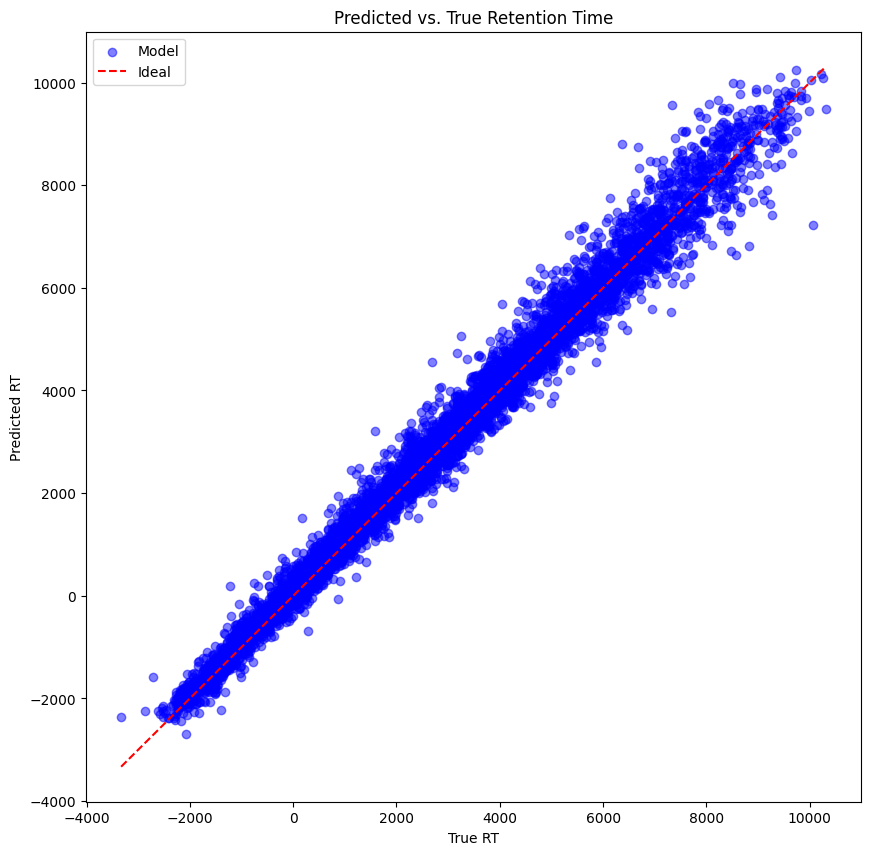

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(all_targets, all_preds, alpha=0.5, label="Model", color="blue")
plt.xlabel("True RT")
plt.ylabel("Predicted RT")
plt.title("Predicted vs. True Retention Time")
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()], 'r--', label="Ideal")
plt.legend()
plt.show()

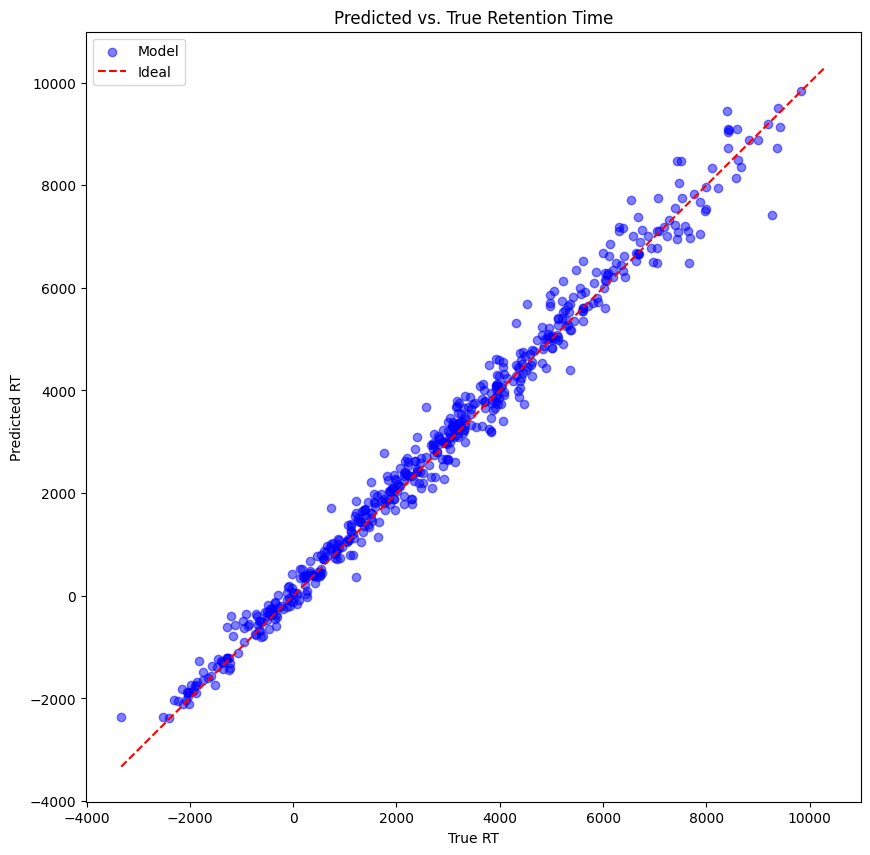

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(all_targets[:552], all_preds[:552], alpha=0.5, label="Model", color="blue")
plt.xlabel("True RT")
plt.ylabel("Predicted RT")
plt.title("Predicted vs. True Retention Time")
plt.plot([all_targets.min(), all_targets.max()],
         [all_targets.min(), all_targets.max()], 'r--', label="Ideal")
plt.legend()
plt.show()

## 5. Outliers

In [8]:
# Calculate errors
errors = all_preds - all_targets
abs_errors = np.abs(errors)
outlier_threshold = np.mean(abs_errors) + 2 * np.std(abs_errors)

# Get outliers with peptide information
outliers = []
for i in np.where(abs_errors > outlier_threshold)[0]:
    outliers.append({
        'peptide': all_peptides[i],
        'true_rt': all_targets[i],
        'pred_rt': all_preds[i],
        'error': errors[i],
        'abs_error': abs_errors[i]
    })

# Sort by worst errors
outliers.sort(key=lambda x: x['abs_error'], reverse=True)

# Display results
print(f"{len(outliers)} outliers found out of {len(all_peptides)} data records (threshold: {outlier_threshold:.4f})")
for outlier in outliers:
    print(f"{outlier['peptide']:40} | True: {outlier['true_rt']:.4f} | Pred: {outlier['pred_rt']:.4f} | Error: {outlier['error']:.4f}")

345 outliers found out of 7329 data records (threshold: 755.1776)
VLGITAQNSSGLTCDPGTGHVAYLAGCVVVILDPK      | True: 10068.0000 | Pred: 7222.2710 | Error: -2845.7290
ISPETLEQDGTVMLPDCHTEGQNILFTDGEYINQIAASR  | True: 6375.0000 | Pred: 8799.6113 | Error: 2424.6113
VIEHIMEDLDTNADKQLSFEEFIMLMAR             | True: 7341.0000 | Pred: 9556.9365 | Error: 2215.9365
GSITSVQAIYVPADDLTDPAPATTFAHLDATTVLSR     | True: 6684.0000 | Pred: 8740.1279 | Error: 2056.1279
QHNYLKDGPYITAEEAVAVYTTTVHWLESR           | True: 8826.0000 | Pred: 6808.4521 | Error: -2017.5479
AHATGAGPAGRYDQATDTILTVTENIFSSMGDAGEMVR   | True: 8580.0000 | Pred: 6636.7212 | Error: -1943.2788
GKLEGADHSCTMGDAEEAQIDDEAHPVLLQPVAK       | True: 2684.0000 | Pred: 4564.8057 | Error: 1880.8057
ILLPEGFNPMQALEELEK                       | True: 9276.0000 | Pred: 7415.2603 | Error: -1860.7397
EGNDLYHEMIESGVINLKDATSK                  | True: 3246.0000 | Pred: 5068.4927 | Error: 1822.4927
NFVEETVYLLSR                             | True: 7314.0000 | Pred

## 6. Predict RT for New Peptide Sequences
Enter your own peptide(s) below.

In [9]:
def predict_peptide_rt(peptide_seq, model, tokenizer, device):
    """
    Predict RT for a single peptide sequence (no padding, mask omitted).
    """
    model.eval()
    seq_tensor = tokenizer.encode(peptide_seq).unsqueeze(0).to(device)
    mask = torch.zeros_like(seq_tensor, dtype=torch.bool)  # all False
    with torch.no_grad():
        pred = model(seq_tensor, mask)
    return float(pred.item())

def predict_peptide_batch_rt(peptide_seqs, model, tokenizer, device):
    """
    Predict RTs for a batch of peptide sequences.
    Returns a list of floats.
    """
    model.eval()
    # Encode all sequences (list of tensors of different lengths)
    seqs = [tokenizer.encode(seq) for seq in peptide_seqs]
    # Pad to same length: (batch, max_len)
    seqs_padded = pad_sequence(seqs, batch_first=True, padding_value=tokenizer.pad_id)
    # Mask: True where <pad>
    key_padding_mask = seqs_padded.eq(tokenizer.pad_id)
    seqs_padded, key_padding_mask = seqs_padded.to(device), key_padding_mask.to(device)
    with torch.no_grad():
        preds = model(seqs_padded, key_padding_mask)  # (batch,)
    return preds.cpu().tolist()

# Read all peptides and real RTs from the file
data = []
with open("data\cysty_test.txt", 'r') as f:
    for line in f:
        line = line.strip()
        if line:  # Skip empty lines
            peptide, rt = line.split('\t')
            data.append((peptide, float(rt)))

comparison_data = data[:22]
peptides = [item[0] for item in comparison_data]
real_rts = [item[1] for item in comparison_data]

# ---- Single prediction ----
single_preds = []
for pep in peptides:
    rt_pred = predict_peptide_rt(pep, model, tokenizer, DEVICE)
    single_preds.append(rt_pred)

# ---- Batch prediction ----
batch_preds = predict_peptide_batch_rt(peptides, model, tokenizer, DEVICE)

# ---- Print comparison table ----
print("\nComparison of Real and Predicted Retention Times:")
print("-" * 85)
print(f"{'Peptide':40}  {'Real RT':>10}  {'Single Pred':>12}  {'Batch Pred':>12}")
print("-" * 85)
for pep, real, single, batch in zip(peptides, real_rts, single_preds, batch_preds):
    print(f"{pep:40}  {real:10.4f}  {single:12.4f}  {batch:12.4f}")

# Optional: Print how many peptides were read in total
print(f"\nTotal peptides in file: {len(data)}")


Comparison of Real and Predicted Retention Times:
-------------------------------------------------------------------------------------
Peptide                                      Real RT   Single Pred    Batch Pred
-------------------------------------------------------------------------------------
VVNRANTVQEAT                                  0.1300     -938.4823     -938.4823
ILDDLSPRDQFN                                  0.4020     2789.3145     2789.3145
HYFAPEGLTTMPK                                 0.3070     2354.6948     2354.6943
SFAAGIQALGGTNINDA                             0.5740     4564.2954     4564.2954
RIHEDSDSALQLQDFYQEVANP                        0.6220     5226.3291     5226.3291
SSHVGGTLGQFYQEVLWGSPAASDDG                    0.7430     6504.1875     6504.1870
HLTFWSLLE                                     0.7530     6799.0376     6799.0361
DADDAKATFDEEEGRDEYDEVAMPV                     0.4960     3976.1797     3976.1797
VQWKVDNALQSGNSQESVTEQDS                       0.

<>:31: SyntaxWarning: invalid escape sequence '\c'
<>:31: SyntaxWarning: invalid escape sequence '\c'
C:\Users\mmakaranka\AppData\Local\Temp\ipykernel_41992\2091348599.py:31: SyntaxWarning: invalid escape sequence '\c'
  with open("data\cysty_test.txt", 'r') as f:
